# Modeling
Goal: Use model to predict vacancy rates for 2019-2020

In [3]:
#imports
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
import datetime
from pandas_profiling import ProfileReport
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from xgboost import XGBClassifier

## Introduction
In this notebook, we will make the final predictions for vacancy rate for the years 2019-2020 using the model created in notebook 4.3

In [4]:
#load data
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/data/processed'
os.chdir(path) 
# subset data into 2014-2018 to create model and 2019-2020 to do final predictions of vacancy rates during that time
df = pd.read_csv('VacancyRate_Zillow_2014_2018')
df19_20 = pd.read_csv('VacancyRate_Zillow_2019_2020')

In [5]:
df

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,State_AL,State_AR,State_AZ,State_CA,...,CountyName_Weber County,CountyName_Weld County,CountyName_Westchester County,CountyName_Will County,CountyName_Williamson County,CountyName_Wilson County,CountyName_Worcester County,CountyName_Yamhill County,CountyName_Yolo County,CountyName_York County
0,10025,3041.83,2014,0.0,968761.75,9.011810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60657,1589.42,2014,1.0,450755.75,8.042922,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10023,3186.67,2014,2.0,1024543.17,19.964756,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77494,1807.33,2014,3.0,322032.00,3.319292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60614,1786.25,2014,4.0,580250.92,8.468203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,2110,4643.58,2018,14752.0,1363870.08,17.412045,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16144,20004,2432.25,2018,15149.0,480942.83,21.036585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16145,80951,1537.18,2018,15318.0,276619.83,1.084746,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16146,11964,20122.17,2018,17169.0,1000069.25,62.044105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#add leading zeros to zipcode
df['Zipcode'] = df['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))
df19_20['Zipcode'] = df19_20['Zipcode'].apply(lambda x: '{0:0>5}'.format(x))

In [7]:
#change Zipcode from ojbect to integer
df.Zipcode = df.Zipcode.astype('int')
df19_20.Zipcode = df19_20.Zipcode.astype('int')
df.dtypes

Zipcode                          int64
RentPrice                      float64
Year                             int64
SizeRank                       float64
HomePrice                      float64
                                ...   
CountyName_Wilson County         int64
CountyName_Worcester County      int64
CountyName_Yamhill County        int64
CountyName_Yolo County           int64
CountyName_York County           int64
Length: 1754, dtype: object

In [8]:
df

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%,State_AL,State_AR,State_AZ,State_CA,...,CountyName_Weber County,CountyName_Weld County,CountyName_Westchester County,CountyName_Will County,CountyName_Williamson County,CountyName_Wilson County,CountyName_Worcester County,CountyName_Yamhill County,CountyName_Yolo County,CountyName_York County
0,10025,3041.83,2014,0.0,968761.75,9.011810,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60657,1589.42,2014,1.0,450755.75,8.042922,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10023,3186.67,2014,2.0,1024543.17,19.964756,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,77494,1807.33,2014,3.0,322032.00,3.319292,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60614,1786.25,2014,4.0,580250.92,8.468203,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16143,2110,4643.58,2018,14752.0,1363870.08,17.412045,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16144,20004,2432.25,2018,15149.0,480942.83,21.036585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16145,80951,1537.18,2018,15318.0,276619.83,1.084746,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16146,11964,20122.17,2018,17169.0,1000069.25,62.044105,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load Model

In [9]:
#define variable X, y
X = df.drop('Vacancy_Rate%', axis=1)
y = df['Vacancy_Rate%']

In [10]:
#split data for test purposes
tss = TimeSeriesSplit(n_splits = 5)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [12]:
#load model
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/models'
os.chdir(path)
filename = 'random_forest_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
#test it worked
result = loaded_model.score(X_test, y_test)
print(result)

0.922208934205951


## Refit Model On All Available Data

In [154]:
loaded_model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [161]:
#perform 5 fold cross validation on all available data
cv_results = cross_validate(loaded_model, X, y, cv=5, n_jobs=-1)

In [162]:
#get R2 scores from cross validation
cv_scores = cv_results['test_score']
cv_scores

array([0.91043894, 0.96673606, 0.97035355, 0.96788022, 0.92274149])

In [163]:
#get mean/std of cv test scores
np.mean(cv_scores), np.std(cv_scores)

(0.9476300529044828, 0.025667430198232713)

In [13]:
#get mean/std of mae 
rf_neg_mae = cross_validate(loaded_model, X, y, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [14]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(1.1545411182306395, 0.2513702265613337)

## Calculate Expected Vacacny Rate for 2019-2020 From The Model

In [179]:
#check NaNs
df19_20.isna().sum()

Zipcode             0
RentPrice           0
Year                0
SizeRank            8
State               6
City                6
Metro               6
CountyName          6
HomePrice           8
Vacancy_Rate%    6486
dtype: int64

In [180]:
#drop NaN rows, for only the rows where vacacny is NOT NaN
df19_20.dropna(subset=['SizeRank', 'State', 'City', 'Metro', 'CountyName', 'HomePrice'], inplace=True)

In [181]:
#check NaNs are dealt with correctly
df19_20.isna().sum()

Zipcode             0
RentPrice           0
Year                0
SizeRank            0
State               0
City                0
Metro               0
CountyName          0
HomePrice           0
Vacancy_Rate%    6478
dtype: int64

In [182]:
#create X and y variables for years 2019-2020
X_19_20 = df19_20.drop('Vacancy_Rate%', axis=1)
y_19_20 = df19_20['Vacancy_Rate%']

In [183]:
#turn categorical variables into binary for predicting with get dummies
X_19_20_dummy = pd.get_dummies(X_19_20)

In [116]:
#loaded_model.score(X_19_20, y_19_20)

In [184]:
#predict the vacancy rates for 2019-2020
pred_19_20 = loaded_model.predict(X_19_20_dummy)

In [185]:
pred_19_20

array([12.41935865,  8.07107598, 19.14261407, ...,  1.18945386,
       59.50802227, 12.96768375])

In [186]:
#add 2019-2020 vacancy rate data to rest of 2019-2020 dataframe
X_19_20['Vacancy_Rate%'] = pred_19_20
predictions_2019_20 = X_19_20
predictions_2019_20

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
0,10025,3241.00,2019,0.0,NY,New York,New York-Newark-Jersey City,New York County,1072056.17,12.419359
1,60657,1784.58,2019,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,490717.08,8.071076
2,10023,3354.83,2019,2.0,NY,New York,New York-Newark-Jersey City,New York County,1053399.33,19.142614
3,77494,1795.08,2019,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,341633.50,3.823386
4,60614,2026.42,2019,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,639591.75,8.111097
...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.191465
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.829785
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.189454
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,59.508022


## Explore 2019-2020 Vacancy Rate Data

In [221]:
#get number of unique States in 2019-2020 Vacancy Rate Data
predictions_2019_20.State.nunique()

43

In [222]:
#get list of unique States by percent of total
predictions_2019_20.State.value_counts()/len(predictions_2019_20)*100

CA    16.455696
FL    14.294535
TX     8.799012
NY     4.353195
VA     4.322322
AZ     4.260574
IL     4.106206
GA     3.890090
WA     3.087373
NC     2.994751
MD     2.933004
CO     2.778635
NJ     2.655140
PA     2.377277
MA     2.161161
MI     1.914171
TN     1.728929
MO     1.667181
NV     1.605434
OH     1.574560
SC     1.481939
MN     1.481939
CT     1.451065
OR     1.204075
IN     0.895338
OK     0.617475
DC     0.555727
HI     0.524853
ID     0.493980
WI     0.370485
KS     0.339611
KY     0.339611
UT     0.339611
LA     0.308737
RI     0.308737
AL     0.277864
NM     0.277864
DE     0.246990
NE     0.216116
MS     0.092621
IA     0.092621
NH     0.092621
AR     0.030874
Name: State, dtype: float64

In [223]:
#Missing States:
#AK, ME, MT, ND, SD, VT, WV, WY

In [224]:
#split 2019-2020 data into separate years
#for more specific analysis
predictions_2019 = predictions_2019_20[predictions_2019_20.Year == 2019]
predictions_2020 = predictions_2019_20[predictions_2019_20.Year == 2020]
predictions_2019

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
0,10025,3241.00,2019,0.0,NY,New York,New York-Newark-Jersey City,New York County,1072056.17,12.419359
1,60657,1784.58,2019,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,490717.08,8.071076
2,10023,3354.83,2019,2.0,NY,New York,New York-Newark-Jersey City,New York County,1053399.33,19.142614
3,77494,1795.08,2019,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,341633.50,3.823386
4,60614,2026.42,2019,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,639591.75,8.111097
...,...,...,...,...,...,...,...,...,...,...
3238,2110,4718.58,2019,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1364140.92,17.759632
3239,20004,2454.67,2019,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,483746.17,22.969258
3240,80951,1603.91,2019,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,292574.83,1.072623
3241,11964,17439.00,2019,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1019944.42,60.939541


In [225]:
#sort all 2020 zipcodes by vacancy rate
predictions_2020.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
6396,89109,2030.67,2020,9205.0,NV,Las Vegas,Las Vegas-Henderson-Paradise,Clark County,303027.67,70.985492
5455,34747,1575.78,2020,4108.0,FL,Citrus Ridge,Orlando-Kissimmee-Sanford,Osceola County,277538.78,67.947222
6464,11978,40654.00,2020,11537.0,NY,Westhampton Beach,New York-Newark-Jersey City,Suffolk County,1171179.44,67.312929
6213,34242,3119.20,2020,6962.0,FL,Siesta Key,North Port-Sarasota-Bradenton,Sarasota County,635396.78,64.041079
6479,11976,36116.00,2020,14009.0,NY,Water Mill,New York-Newark-Jersey City,Suffolk County,2869004.11,61.569151
...,...,...,...,...,...,...,...,...,...,...
5742,7430,2185.22,2020,4958.0,NJ,Mahwah Township,New York-Newark-Jersey City,Bergen County,475482.11,2.266788
5991,75022,1988.44,2020,5835.0,TX,Flower Mound,Dallas-Fort Worth-Arlington,Denton County,491887.44,2.156767
6347,19096,1838.78,2020,8249.0,PA,Wynnewood,Philadelphia-Camden-Wilmington,Montgomery County,565340.67,2.108213
6323,95391,2649.00,2020,7967.0,CA,Tracy,Stockton-Lodi,San Joaquin County,661270.11,2.060244


In [226]:
#look at states grouped by avg vacancy rate
state_groups = predictions_2020.groupby(['State']).mean()
state_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
State,,,,,,
LA,70253.700000,1452.822000,2020.0,3564.000000,335594.409000,17.120390
FL,33397.909287,1714.403175,2020.0,3686.624190,282784.038531,16.896851
RI,2880.300000,1702.075000,2020.0,3805.100000,339608.178000,13.175903
NV,89108.153846,1416.171538,2020.0,3021.019231,295219.265000,12.962914
NY,11001.468085,4041.434894,2020.0,3378.063830,748244.463262,12.126976
AZ,85278.268116,1480.093551,2020.0,2998.152174,318899.116739,12.109672
AR,72205.000000,952.000000,2020.0,3580.000000,174018.440000,10.780341
OH,44176.980392,1137.472941,2020.0,2737.039216,178799.431373,10.304376
DE,19780.625000,1413.081250,2020.0,3554.000000,217653.166250,10.199358


In [307]:
#look at County Names grouped by avg vacancy rate
county_groups = predictions_2020.groupby(['CountyName']).mean()
county_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
CountyName,,,,,,
Osceola County,34637.750000,1632.111250,2020.0,3628.000000,250313.486250,32.823936
El Dorado County,95956.000000,2004.890000,2020.0,3695.000000,562876.665000,26.939488
Sarasota County,34251.750000,1946.546500,2020.0,5136.650000,323782.827000,24.988884
Lee County,33962.941176,1645.269412,2020.0,3989.000000,237688.725882,24.806536
Martin County,34984.500000,1891.827500,2020.0,3089.500000,318070.585000,24.316925
...,...,...,...,...,...,...
Broomfield County,80021.500000,1965.885000,2020.0,3023.500000,543740.280000,3.419585
Manassas Park City,20111.000000,1761.890000,2020.0,3694.000000,358269.890000,3.359100
Weld County,80634.000000,1685.330000,2020.0,235.000000,363341.780000,3.345164


In [309]:
#look at Metro Area grouped by avg vacancy rate
metro_groups = predictions_2020.groupby(['Metro']).mean()
metro_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
Metro,,,,,,
Cape Coral-Fort Myers,33962.941176,1645.269412,2020.0,3989.000000,237688.725882,24.806536
North Port-Sarasota-Bradenton,34237.700000,1858.205000,2020.0,4372.666667,304210.458667,23.613684
Port St. Lucie,34975.636364,1793.530000,2020.0,3868.000000,277064.250909,21.549641
Lakeland-Winter Haven,33955.733333,1391.704667,2020.0,3659.800000,196345.281333,18.943737
Deltona-Daytona Beach-Ormond Beach,32351.000000,1448.252143,2020.0,3189.214286,220492.952857,18.090061
...,...,...,...,...,...,...
Colorado Springs,80869.571429,1549.760476,2020.0,4688.761905,333060.587619,4.389703
Provo-Orem,84218.000000,1369.886667,2020.0,3717.000000,342798.703333,4.346168
Fort Collins,80529.333333,1616.076667,2020.0,777.333333,407307.850000,3.992856


In [310]:
#look at City grouped by avg vacancy rate
city_groups = predictions_2020.groupby(['City']).mean()
city_groups.sort_values('Vacancy_Rate%', ascending=False)

,Zipcode,RentPrice,Year,SizeRank,HomePrice,Vacancy_Rate%
City,,,,,,
Westhampton Beach,11978.0,40654.00,2020.0,11537.0,1171179.44,67.312929
Siesta Key,34242.0,3119.20,2020.0,6962.0,635396.78,64.041079
Water Mill,11976.0,36116.00,2020.0,14009.0,2869004.11,61.569151
Town of Shelter Island,11964.0,15800.50,2020.0,17169.0,1015162.00,59.508022
Longboat Key,34228.0,4370.00,2020.0,6604.0,661044.44,59.073124
...,...,...,...,...,...,...
Chester Springs,19425.0,2150.57,2020.0,8516.0,485948.33,2.577594
West Jordan,84081.0,1609.56,2020.0,2931.0,392626.33,2.380693
Burke,22015.0,2414.56,2020.0,2302.0,553685.78,2.273028


## Combine 2014-2018 & 2019-2020 Data for exploration

In [227]:
#load data without dummy variables
path= '/Users/josephfrasca/Coding_Stuff/Springboard/Capstone_2/data/interim'
os.chdir(path) 
df2 = pd.read_csv('vacancy_zillowHomeRent_merge_2014_2020.csv', dtype={'Zipcode': object})
df2.head()

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%,MOE-VacancyRate%
0,10025,3041.83,2014,0.0,NY,New York,New York-Newark-Jersey City,New York County,968761.75,9.011810,1.539867
1,60657,1589.42,2014,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,450755.75,8.042922,1.343734
2,10023,3186.67,2014,2.0,NY,New York,New York-Newark-Jersey City,New York County,1024543.17,19.964756,2.296513
3,77494,1807.33,2014,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,322032.00,3.319292,1.229599
4,60614,1786.25,2014,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,580250.92,8.468203,1.250484


In [228]:
#drop margin of error of vacancy rate
df2.drop('MOE-VacancyRate%', axis=1, inplace=True)

In [229]:
#preserve 2014-2018 data
df2 = df2[df2.Year < 2019]

In [230]:
#check NaNs
df2.isna().sum()/len(df2)*100

Zipcode          0.000000
RentPrice        0.018501
Year             0.000000
SizeRank         0.123343
State            0.092507
City             0.092507
Metro            0.092507
CountyName       0.092507
HomePrice        0.240518
Vacancy_Rate%    0.154178
dtype: float64

In [231]:
#drop NaNs
df2.dropna(inplace=True)

In [232]:
#change zipcode into integer
df2.Zipcode = df2.Zipcode.astype('int')
df2.dtypes

Zipcode            int64
RentPrice        float64
Year               int64
SizeRank         float64
State             object
City              object
Metro             object
CountyName        object
HomePrice        float64
Vacancy_Rate%    float64
dtype: object

In [234]:
#concat 2014-2018 data with 2019-2020
df14_20 = pd.concat([df2, predictions_2019_20])
df14_20

,Zipcode,RentPrice,Year,SizeRank,State,City,Metro,CountyName,HomePrice,Vacancy_Rate%
0,10025,3041.83,2014,0.0,NY,New York,New York-Newark-Jersey City,New York County,968761.75,9.011810
1,60657,1589.42,2014,1.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,450755.75,8.042922
2,10023,3186.67,2014,2.0,NY,New York,New York-Newark-Jersey City,New York County,1024543.17,19.964756
3,77494,1807.33,2014,3.0,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,322032.00,3.319292
4,60614,1786.25,2014,4.0,IL,Chicago,Chicago-Naperville-Elgin,Cook County,580250.92,8.468203
...,...,...,...,...,...,...,...,...,...,...
6481,2110,4408.57,2020,14752.0,MA,Boston,Boston-Cambridge-Newton,Suffolk County,1339232.44,18.191465
6482,20004,2505.56,2020,15149.0,DC,Washington,Washington-Arlington-Alexandria,District of Columbia,497022.00,22.829785
6483,80951,1647.88,2020,15318.0,CO,Colorado Springs,Colorado Springs,El Paso County,315486.22,1.189454
6484,11964,15800.50,2020,17169.0,NY,Town of Shelter Island,New York-Newark-Jersey City,Suffolk County,1015162.00,59.508022


<AxesSubplot:xlabel='Year', ylabel='Vacancy_Rate%'>

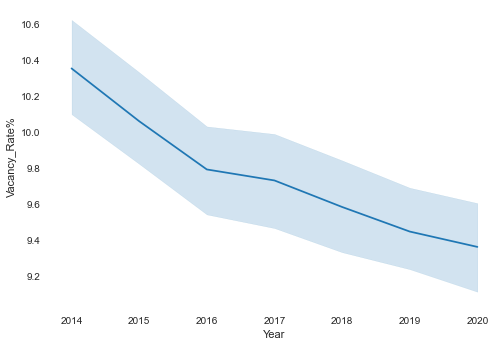

In [236]:
#plot average vacany rate over time
sns.lineplot(data=df14_20, x="Year", y="Vacancy_Rate%")

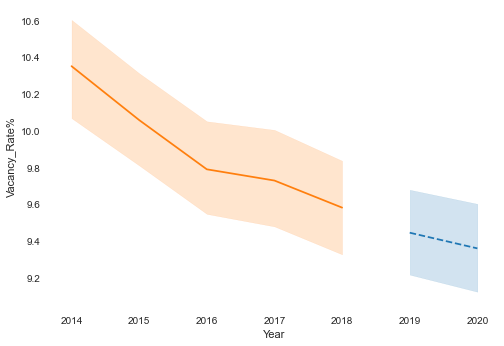

In [244]:
#plot 19-20 data with dotted line
ax = sns.lineplot(data=predictions_2019_20, x="Year", y="Vacancy_Rate%")

# Might need to loop through the list if there are multiple lines on the plot
ax.lines[0].set_linestyle("--")

sns.lineplot(data=df2, x="Year", y="Vacancy_Rate%")

plt.show()

In [255]:
#look at years grouped by avg vacancy rate
year_groups = df14_20.groupby(['Year']).mean()
year_groups.reset_index(inplace=True)
year_groups

,Year,Zipcode,RentPrice,SizeRank,HomePrice,Vacancy_Rate%
0,2014,53908.184472,1540.939537,3196.855280,323535.848193,10.350332
1,2015,53825.279740,1641.556704,3205.623916,343732.276853,10.056811
2,2016,53824.307240,1701.844341,3206.472153,365480.607618,9.788604
3,2017,53810.133271,1756.986478,3205.861163,388186.640025,9.727441
4,2018,53810.133271,1805.311079,3205.861163,414801.991456,9.580019
5,2019,53822.729237,1856.936789,3206.279716,424215.916644,9.443343
6,2020,53822.729237,1889.907984,3206.279716,438340.191575,9.358013


In [276]:
#drop columns not of interest when looking at average per year
year_groups.drop(['Zipcode', 'SizeRank'], axis=1, inplace=True)

<AxesSubplot:xlabel='Year', ylabel='RentPrice'>

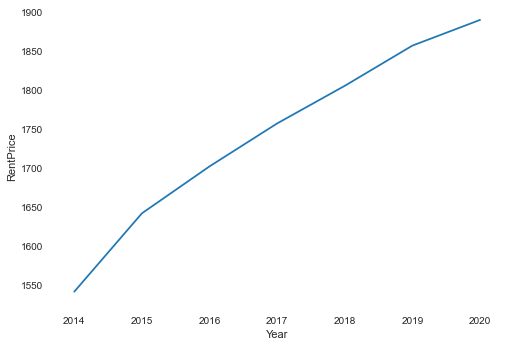

In [274]:
#plot average rent price per year
sns.lineplot(data=year_groups, x="Year", y="RentPrice")

<AxesSubplot:xlabel='Year', ylabel='HomePrice'>

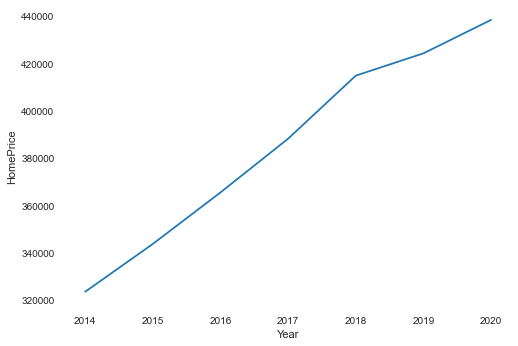

In [275]:
#plot average home price per year
sns.lineplot(data=year_groups, x="Year", y="HomePrice")

<AxesSubplot:xlabel='Year', ylabel='Vacancy_Rate%'>

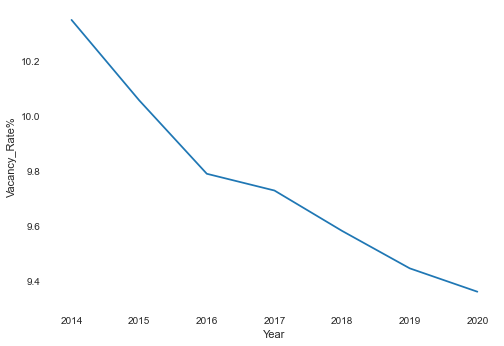

In [279]:
#plot average vacany per year
sns.lineplot(data=year_groups, x="Year", y="Vacancy_Rate%")

In [295]:
#look at std by year
df_std = df14_20.groupby('Year').std()
df_std.reset_index(inplace=True)
df_std.drop(['Zipcode', 'SizeRank'], axis=1, inplace=True)

In [298]:
df_std

,Year,RentPrice,HomePrice,Vacancy_Rate%
0,2014,1786.649568,270087.107257,7.512805
1,2015,2033.172548,294223.503928,7.475292
2,2016,1936.692901,314062.458276,7.446735
3,2017,1991.368197,332753.945356,7.449679
4,2018,1816.755186,362936.496822,7.399814
5,2019,1652.270953,362576.708835,7.022643
6,2020,1524.078903,373208.937008,6.968915


<AxesSubplot:xlabel='Year', ylabel='Vacancy_Rate%'>

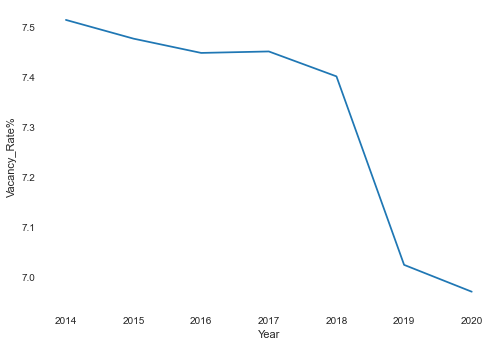

In [301]:
#plot std vacancy rate by year
sns.lineplot(data=df_std, x="Year", y="Vacancy_Rate%")

<AxesSubplot:xlabel='Year', ylabel='RentPrice'>

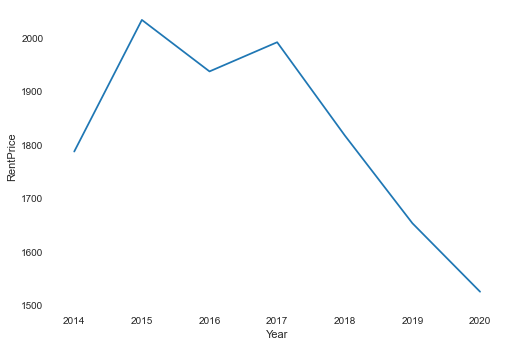

In [304]:
#plot std rent price by year
sns.lineplot(data=df_std, x="Year", y="RentPrice")

<AxesSubplot:xlabel='Year', ylabel='HomePrice'>

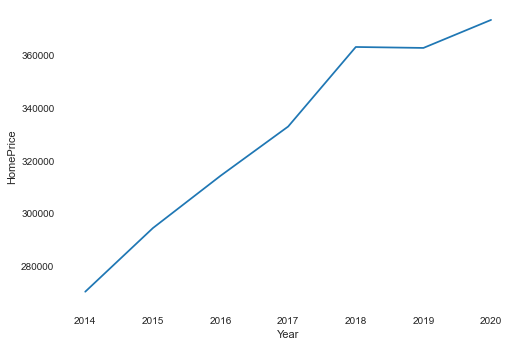

In [305]:
#plot std home price price by year
sns.lineplot(data=df_std, x="Year", y="HomePrice")

In [311]:
#try and plot all 3 stds on one axis

#dfstd = df_std.melt('Year', var_name='cols',  value_name='vals')
#g = sns.factorplot(x="Year", y="vals", hue='cols', data=dfstd)

## Summary

- loaded data, model and refit model with all available data (2014-2018)
- performed 5 fold cross validation on all available data
    - mean test cv score: 0.95
    - std. test cv score: 0.03
    - mean absolute error: 1.15, std: 0.25

Calculated Expected Vacacny Rate for 2019-2020 From The Model
- dropped NaN rows in 2019-2020 data, for only the rows where vacacny is NOT NaN
- create X and y variables for years 2019-2020
- turned categorical variables into binary for predicting with get dummies
- predicted the vacancy rates for 2019-2020
- added 2019-2020 vacancy rate data to rest of 2019-2020 dataframe

Explored 2019-2020 Vacancy Rate Data
- saw number of unique States in 2019-2020 Vacancy Rate Data was 43
- examined states and determined missing states were AK, ME, MT, ND, SD, VT, WV, and WY
- split 2019-2020 data into separate years for more specific analysis
- looked at highest/lowest vacancy rate by:
    - zipcode
    - State
    - County
    - Metro Area
    - City
    
Combine 2014-2018 & 2019-2020 Data for exploration
- loaded 2014-2018 data without dummy variables and cleaned it
- concated 2014-2018 data with 2019-2020
- plot average vacany rate over time
    - lineplot of 2019-2020 predictions seems to roughly follow trend of 2019-2020 national data


#.... maybe just list this in further work b/c time is short...find areas to invest (rent/price ratios adjusted for vacancy).

##NOTE THIS IS NOT REPRESENTATIVE OF ALL ZIPCODES B/C ZILLOW ONLY HAD ~3000 zipcodes with rent prices vs. ~33k with home prices
    #note that this is most likely representative to more dense areas due to having rental price data (ie. cities etc.)

## Further Work

In [ ]:
#MISSING LOTS OF ZIPCODES AND STATES
    #Missing States:
    #AK, ME, MT, ND, SD, VT, WV, WY
#need to go back and deal with NaNs better (drop only all NaN), groupby year, and then linear fill?
#need to get rental data from ACS...

#add in other zipcodes (get rent data from ACS)
#find areas to invest (rent/price ratios adjusted for vacancy).
    #add other variables to find areas to invest (ie. crime rates, unemployment rates, etc.)
    
